In [369]:
# load libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt


In [370]:
# load saved training/validation/test data
with open('train_val_test_data.pkl', 'rb') as file:
    X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(file)

In [371]:
# loads the data from the pkl file into X_train, X_val, and X_test
full_columns = ['password', 'length', 'length_bin', 'uppercase_count', 'lowercase_count', 'numbers_count', 'special_character_count', 'entropy', 
                'ngram_occurrences', 'character_diversity', 'contains_name', 
                'upper_special', 'length_entropy', 'lower_numbers', 'entropy_special',
                'upper_ratio', 'lower_ratio', 'special_character_ratio', 'numbers_ratio', 'entropy_per_character']
X_train_full_df = pd.DataFrame(X_train, columns=full_columns)
X_val_full_df = pd.DataFrame(X_val, columns=full_columns)
X_test_full_df = pd.DataFrame(X_test, columns=full_columns)

In [372]:
# Model 1: Character-Based Features 
# create X_train, X_val, and X_test for model 1
model1_columns = ['length', 'entropy', 'contains_name']
X_train_model1 = X_train_full_df[model1_columns].to_numpy().astype(np.float64)
X_val_model1 = X_val_full_df[model1_columns].to_numpy().astype(np.float64)
X_test_model1 = X_test_full_df[model1_columns].to_numpy().astype(np.float64)

In [373]:
# Model 2: Semantic Features
model2_columns = ['uppercase_count', 'lowercase_count', 'numbers_count', 'special_character_count', 'contains_name']
X_train_model2 = X_train_full_df[model2_columns].to_numpy().astype(np.float64)
X_val_model2 = X_val_full_df[model2_columns].to_numpy().astype(np.float64)
X_test_model2 = X_test_full_df[model2_columns].to_numpy().astype(np.float64)

In [374]:
# Model 3: Combined Features

model3_columns = ['upper_special', 'length_entropy', 'entropy_special', 'upper_ratio', 'lower_ratio', 
                  'special_character_ratio', 'numbers_ratio', 'entropy_per_character']
X_train_model3 = X_train_full_df[model3_columns].to_numpy().astype(np.float64)
X_val_model3 = X_val_full_df[model3_columns].to_numpy().astype(np.float64)
X_test_model3 = X_test_full_df[model3_columns].to_numpy().astype(np.float64)


In [375]:
# Model 4: Model with all of the features available
full_model_columns = ['length', 'uppercase_count', 'uppercase_count', 'lowercase_count', 'numbers_count', 'special_character_count', 'contains_name',
                      'upper_special', 'length_entropy', 'lower_numbers', 'entropy_special', 'upper_ratio', 'lower_ratio', 
                      'special_character_ratio', 'numbers_ratio', 'entropy_per_character']
X_train_full_model = X_train_full_df[full_model_columns].to_numpy().astype(np.float64)
X_val_full_model = X_val_full_df[full_model_columns].to_numpy().astype(np.float64)
X_test_full_model = X_test_full_df[full_model_columns].to_numpy().astype(np.float64)

In [376]:
# calculate accuracy given the true labels and the predictions
def accuracy(y_truth, y_pred):
    correct_pred = 0
    # iterate through the values and check if the labels are the same, update as required
    for y_t, y_p in zip(y_truth, y_pred):
        if y_t == y_p :
            correct_pred += 1
    # find the proportion by dividing the correct predictions by all the predictions
    return correct_pred / len(y_truth)

In [377]:
# softmax function
def softmax(z):
   exp_z = np.exp(z - np.max(z, axis = 1, keepdims = True))
   return exp_z / np.sum(exp_z, axis = 1, keepdims = True)

In [378]:
# logistic regression function using softmax instead of sigmoid for multinomial classification (gradient descent)
def logistic_regression(X, y, num_classes, iterations, learning_rate):
   # add bias terms
   X = np.hstack((np.ones((X.shape[0], 1)), X))

   # initialize the weights
   w = np.ones((num_classes, X.shape[1]))

   # gradient descent, adjust weights iteratively using the learning rate
   for i in range(iterations):
      # find the predicted 
      class_probabilities = softmax(X.dot(w.T))

      # one hot encoding of labels
      y_one_hot = np.eye(num_classes)[y].reshape(len(y), num_classes)

      # calculate gradient and adjust the weights
      gradient = (class_probabilities - y_one_hot).T.dot(X) / len(y)
      w -= learning_rate * gradient
   return w

In [379]:
# single model predictor -- predict class using softmax and weights
def softmax_prediction(X, w):
   # add bias terms
   X = np.hstack((np.ones((X.shape[0], 1)), X))
   # return the class with the highest probability as the predicted label
   return np.argmax(softmax(X.dot(w.T)), axis = 1)

In [380]:
# makes predictions based on weighted sum
def lr_weighted_sum_voting_predictions(X_models, w_models, weights=[0.33, 0.34, 0.33]):
    # finds the total number of models based on size of X_models input
    num_models = len(X_models)

    # creates array of predictions for each of the models
    predictions = []
    for i in range(num_models):
        curr_model_prediction = softmax_prediction(X_models[i], w_models[i])
        predictions.append(curr_model_prediction)

    # finds expected value for predictions based on given weights
    return (weights[0] * predictions[0] + weights[1] * predictions[1] + weights[2] * predictions[2]).astype(int)


In [381]:
#creates predictions with votes, equal
def lr_hard_voting_predictions(X_models, w_models):

    # create an array of predictions for all three models
    num_models = len(X_models)
    predictions = []

    for i in range(num_models):
        curr_model_prediction = softmax_prediction(X_models[i], w_models[i])
        predictions.append(curr_model_prediction)

    # reshapes the predictions for voting
    predictions = np.stack(predictions, axis=0) 

    _, num_samples = predictions.shape
    num_classes = 5  

    final_preds = []
    for i in range(num_samples):

        # creates an array to tally up the counts for each of the classes
        vote_counts = np.zeros(num_classes)

        # iterates through the models
        for i in range(num_models):
            # finds the predicted class and adds 1 to the class count
            class_pred = predictions[i, i]
            vote_counts[class_pred] += 1
        # appends to final prediction
        final_preds.append(np.argmax(vote_counts))

    return np.array(final_preds)

In [382]:
# creates predictions with votes, biased towards more accurate models
def lr_weighted_hard_voting(X_models, w_models, weights):
    # creates predictions
    num_models = len(X_models)
    predictions = []
    for i in range(num_models):
        curr_model_prediction = softmax_prediction(X_models[i], w_models[i])
        predictions.append(curr_model_prediction)

    # reshapes the predictions for voting
    predictions = np.stack(predictions, axis=0) 

    _, num_samples = predictions.shape
    num_classes = 5  

    final_preds = []
    for i in range(num_samples):

        # creates an array to tally up the counts for each of the classes
        vote_counts = np.zeros(num_classes)

        # iterates through the models
        for i in range(num_models):
            # finds the predicted class and adds weight to the class count
            class_pred = predictions[i, i]
            vote_counts[class_pred] += weights[i]
        # appends to final prediction
        final_preds.append(np.argmax(vote_counts))

    return np.array(final_preds)

In [343]:
# train log reg model 1
weights_model1 = logistic_regression(X_train_model1, y_train, 5, 150000, 0.025)

In [344]:
# train log reg model 2
weights_model2 = logistic_regression(X_train_model2, y_train, 5, 150000, 0.045)

In [345]:
# train log reg model 3
weights_model3 = logistic_regression(X_train_model3, y_train, 5, 150000, 0.005)

In [390]:
# train log reg model full
weights_full_model = logistic_regression(X_train_full_model, y_train, 5, 150000, 0.03)

In [346]:
# predicts based on weighted sum voting 
train_predictions = lr_weighted_sum_voting_predictions([X_train_model1, X_train_model2, X_train_model3], 
                                           [weights_model1, weights_model2, weights_model3],
                                           [0.2, 0.6, 0.2])
train_accuracy = accuracy(y_train.reshape(1, -1)[0], train_predictions)
print(train_accuracy)
val_predictions = lr_weighted_sum_voting_predictions([X_val_model1, X_val_model2, X_val_model3], 
                                           [weights_model1, weights_model2, weights_model3],
                                           [0.2, 0.6, 0.2])
val_accuracy = accuracy(y_val.reshape(1, -1)[0], val_predictions)
print(val_accuracy)
test_predictions = lr_weighted_sum_voting_predictions([X_test_model1, X_test_model2, X_test_model3], 
                                           [weights_model1, weights_model2, weights_model3],
                                           [0.2, 0.6, 0.2])
test_accuracy = accuracy(y_test.reshape(1, -1)[0], test_predictions)
print(test_accuracy)

0.8639375
0.8635
0.865


In [347]:
# predicts based on hard voting, equal 
train_predictions = lr_hard_voting_predictions([X_train_model1, X_train_model2, X_train_model3], 
                                           [weights_model1, weights_model2, weights_model3])
train_accuracy = accuracy(y_train.reshape(1, -1)[0], train_predictions)
print(train_accuracy)
val_predictions = lr_hard_voting_predictions([X_val_model1, X_val_model2, X_val_model3], 
                                           [weights_model1, weights_model2, weights_model3])
val_accuracy = accuracy(y_val.reshape(1, -1)[0], val_predictions)
print(train_accuracy)
train_predictions = lr_hard_voting_predictions([X_train_model1, X_train_model2, X_train_model3], 
                                           [weights_model1, weights_model2, weights_model3])
train_accuracy = accuracy(y_train.reshape(1, -1)[0], train_predictions)
print(train_accuracy)

0.9467875
0.9467875
0.9467875


In [348]:
# predicts based on hard voting, weighted/biased

weights = [1.5, 2, 1.5]
train_predictions = lr_weighted_hard_voting([X_train_model1, X_train_model2, X_train_model3], 
                                           [weights_model1, weights_model2, weights_model3],
                                           weights)
train_accuracy = accuracy(y_train.reshape(1, -1)[0], train_predictions)
print(train_accuracy)

val_predictions = lr_weighted_hard_voting([X_val_model1, X_val_model2, X_val_model3], 
                                           [weights_model1, weights_model2, weights_model3],
                                           weights)
val_accuracy = accuracy(y_val.reshape(1, -1)[0], val_predictions)
print(val_accuracy)
test_predictions = lr_weighted_hard_voting([X_test_model1, X_test_model2, X_test_model3], 
                                           [weights_model1, weights_model2, weights_model3],
                                           weights)
test_accuracy = accuracy(y_test.reshape(1, -1)[0], test_predictions)
print(train_accuracy)

0.9466875
0.9508
0.9466875


In [349]:
# model 1 - find the accuracy metrics for each set of data using logistic regression weights for a single mode
train_predictions = softmax_prediction(X_train_model1, weights_model1)
train_accuracy = accuracy(y_train.reshape(1, -1)[0], train_predictions)
print("Logistic Regression Train Accuracy:", train_accuracy)

val_predictions = softmax_prediction(X_val_model1, weights_model1)
val_accuracy = accuracy(y_val.reshape(1, -1)[0], val_predictions)
print("Logistic Regression Validation Accuracy:", val_accuracy)

test_predictions = softmax_prediction(X_test_model1, weights_model1)
test_accuracy = accuracy(y_test.reshape(1, -1)[0], test_predictions)
print("Logistic Regression Test Accuracy:", test_accuracy)

Logistic Regression Train Accuracy: 0.9408
Logistic Regression Validation Accuracy: 0.9457
Logistic Regression Test Accuracy: 0.9383


In [350]:
# model 2 - find the accuracy metrics for each set of data using logistic regression weights for a single mode
train_predictions = softmax_prediction(X_train_model2, weights_model2)
train_accuracy = accuracy(y_train.reshape(1, -1)[0], train_predictions)
print("Logistic Regression Train Accuracy:", train_accuracy)

val_predictions = softmax_prediction(X_val_model2, weights_model2)
val_accuracy = accuracy(y_val.reshape(1, -1)[0], val_predictions)
print("Logistic Regression Validation Accuracy:", val_accuracy)

test_predictions = softmax_prediction(X_test_model2, weights_model2)
test_accuracy = accuracy(y_test.reshape(1, -1)[0], test_predictions)
print("Logistic Regression Test Accuracy:", test_accuracy)

Logistic Regression Train Accuracy: 0.880575
Logistic Regression Validation Accuracy: 0.8774
Logistic Regression Test Accuracy: 0.8792


In [351]:
# model 3 - find the accuracy metrics for each set of data using logistic regression weights for a single mode
train_predictions = softmax_prediction(X_train_model3, weights_model3)
train_accuracy = accuracy(y_train.reshape(1, -1)[0], train_predictions)
print("Logistic Regression Train Accuracy:", train_accuracy)

val_predictions = softmax_prediction(X_val_model3, weights_model3)
val_accuracy = accuracy(y_val.reshape(1, -1)[0], val_predictions)
print("Logistic Regression Validation Accuracy:", val_accuracy)

test_predictions = softmax_prediction(X_test_model3, weights_model3)
test_accuracy = accuracy(y_test.reshape(1, -1)[0], test_predictions)
print("Logistic Regression Test Accuracy:", test_accuracy)

Logistic Regression Train Accuracy: 0.8695875
Logistic Regression Validation Accuracy: 0.8694
Logistic Regression Test Accuracy: 0.8647


In [391]:
# model 4 (full) - find the accuracy metrics for each set of data using logistic regression weights for a single mode
train_predictions = softmax_prediction(X_train_full_model, weights_full_model)
train_accuracy = accuracy(y_train.reshape(1, -1)[0], train_predictions)
print("Logistic Regression Train Accuracy:", train_accuracy)

val_predictions = softmax_prediction(X_val_full_model, weights_full_model)
val_accuracy = accuracy(y_val.reshape(1, -1)[0], val_predictions)
print("Logistic Regression Validation Accuracy:", val_accuracy)

test_predictions = softmax_prediction(X_test_full_model, weights_full_model)
test_accuracy = accuracy(y_test.reshape(1, -1)[0], test_predictions)
print("Logistic Regression Test Accuracy:", test_accuracy)

Logistic Regression Train Accuracy: 0.6839875
Logistic Regression Validation Accuracy: 0.6874
Logistic Regression Test Accuracy: 0.6823


In [ ]:
# create a list of params to test for each of the hyperparameters
params = np.arange(0.005, 0.05, 0.005)
lr_params = np.arange(0.005, 0.05, 0.005)
iter_params = np.arange(5000, 225000, 25000)

In [ ]:
# model 1 - calculate accuracies for each of the params in list and store in arrays 
train_accuracies_m1 = []
val_accuracies_m1 = []
test_accuracies_m1 = []

for param in params:
    weights_model1 = logistic_regression(X_train_model1, y_train, 5, 5000, param)
    
    train_predictions = softmax_prediction(X_train_model1, weights_model1)
    train_accuracy = accuracy(y_train.reshape(1, -1)[0], train_predictions)
    train_accuracies_m1.append(train_accuracy)

    val_predictions = softmax_prediction(X_val_model1, weights_model1)
    val_accuracy = accuracy(y_val.reshape(1, -1)[0], val_predictions)
    val_accuracies_m1.append(val_accuracy)

    test_predictions = softmax_prediction(X_test_model1, weights_model1)
    test_accuracy = accuracy(y_test.reshape(1, -1)[0], test_predictions)
    test_accuracies_m1.append(test_accuracy)

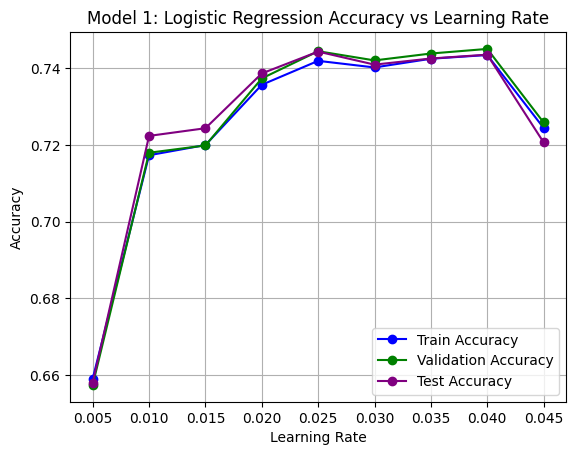

In [ ]:
# model 1 - plot the accuracies
plt.plot(params, train_accuracies_m1, marker='o', color='blue', label='Train Accuracy')
plt.plot(params, val_accuracies_m1, marker='o', color='green', label='Validation Accuracy')
plt.plot(params, test_accuracies_m1, marker='o', color='purple', label='Test Accuracy')

plt.title('Model 1: Logistic Regression Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

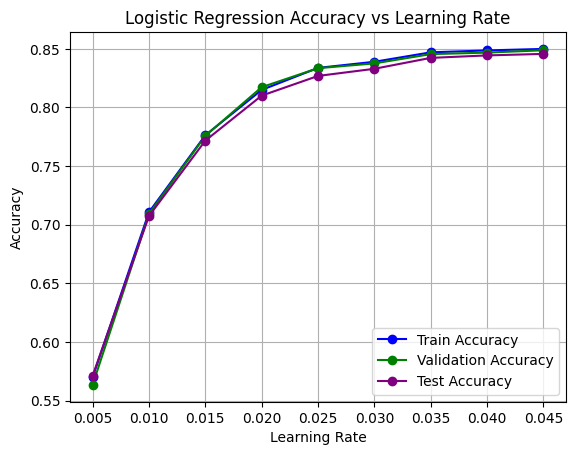

In [ ]:
# model 2 - calculate accuracies for each of the params in list and store in arrays 
train_accuracies_m2 = []
val_accuracies_m2 = []
test_accuracies_m2 = []

for param in params:
    weights_model2 = logistic_regression(X_train_model2, y_train, 5, 5000, param)
    
    train_predictions = softmax_prediction(X_train_model2, weights_model2)
    train_accuracy = accuracy(y_train.reshape(1, -1)[0], train_predictions)
    train_accuracies_m2.append(train_accuracy)

    val_predictions = softmax_prediction(X_val_model2, weights_model2)
    val_accuracy = accuracy(y_val.reshape(1, -1)[0], val_predictions)
    val_accuracies_m2.append(val_accuracy)

    test_predictions = softmax_prediction(X_test_model2, weights_model2)
    test_accuracy = accuracy(y_test.reshape(1, -1)[0], test_predictions)
    test_accuracies_m2.append(test_accuracy)


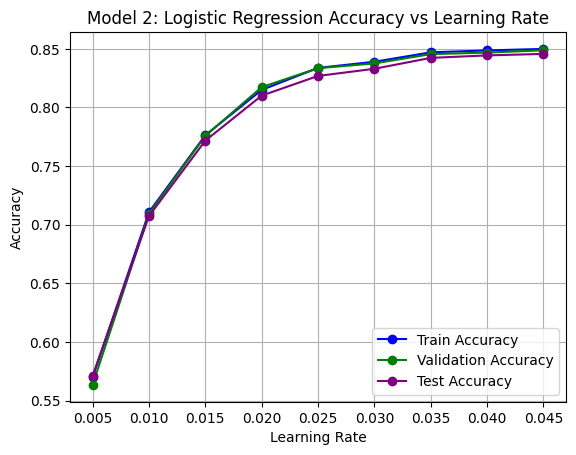

In [ ]:
# model 2 - plot the accuracies for hyperparameter test
plt.plot(params, train_accuracies_m2, marker='o', color='blue', label='Train Accuracy')
plt.plot(params, val_accuracies_m2, marker='o', color='green', label='Validation Accuracy')
plt.plot(params, test_accuracies_m2, marker='o', color='purple', label='Test Accuracy')

plt.title('Model 2: Logistic Regression Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

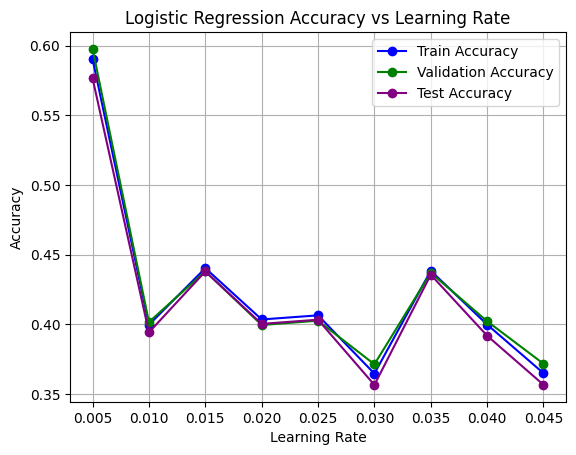

In [ ]:
# model 3 - calculate accuracies for each of the params in list and store in arrays 

train_accuracies_m3 = []
val_accuracies_m3 = []
test_accuracies_m3 = []

for param in params:
    weights_model3 = logistic_regression(X_train_model3, y_train, 5, 5000, param)
    
    train_predictions = softmax_prediction(X_train_model3, weights_model3)
    train_accuracy = accuracy(y_train.reshape(1, -1)[0], train_predictions)
    train_accuracies_m3.append(train_accuracy)

    val_predictions = softmax_prediction(X_val_model3, weights_model3)
    val_accuracy = accuracy(y_val.reshape(1, -1)[0], val_predictions)
    val_accuracies_m3.append(val_accuracy)

    test_predictions = softmax_prediction(X_test_model3, weights_model3)
    test_accuracy = accuracy(y_test.reshape(1, -1)[0], test_predictions)
    test_accuracies_m3.append(test_accuracy)


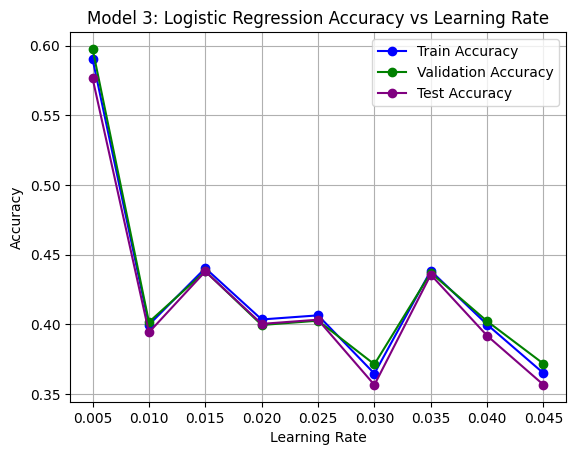

In [ ]:
# model 3 - plot the accuracies for hyperparameter test
plt.plot(params, train_accuracies_m3, marker='o', color='blue', label='Train Accuracy')
plt.plot(params, val_accuracies_m3, marker='o', color='green', label='Validation Accuracy')
plt.plot(params, test_accuracies_m3, marker='o', color='purple', label='Test Accuracy')

plt.title('Model 3: Logistic Regression Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [383]:
# model 4 (full) - calculate accuracies for each of the params in list and store in arrays 

train_accuracies_mfull = []
val_accuracies_mfull = []
test_accuracies_mfull = []

for param in params:
    weights_full_model = logistic_regression(X_train_full_model, y_train, 5, 5000, param)
    
    train_predictions = softmax_prediction(X_train_full_model, weights_full_model)
    train_accuracy = accuracy(y_train.reshape(1, -1)[0], train_predictions)
    train_accuracies_mfull.append(train_accuracy)

    val_predictions = softmax_prediction(X_val_full_model, weights_full_model)
    val_accuracy = accuracy(y_val.reshape(1, -1)[0], val_predictions)
    val_accuracies_mfull.append(val_accuracy)

    test_predictions = softmax_prediction(X_test_full_model, weights_full_model)
    test_accuracy = accuracy(y_test.reshape(1, -1)[0], test_predictions)
    test_accuracies_mfull.append(test_accuracy)


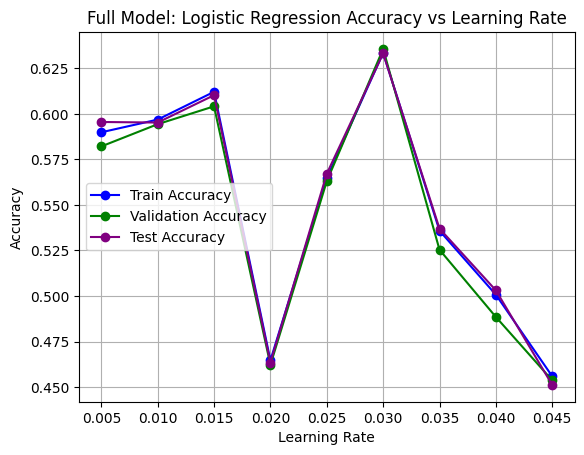

In [387]:
# model 4 (full) - plot the accuracies for hyperparameter test
plt.plot(params, train_accuracies_mfull, marker='o', color='blue', label='Train Accuracy')
plt.plot(params, val_accuracies_mfull, marker='o', color='green', label='Validation Accuracy')
plt.plot(params, test_accuracies_mfull, marker='o', color='purple', label='Test Accuracy')

plt.title('Full Model: Logistic Regression Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()